# Model Evaluation: Train, Validation, and Test Data
## Data Preprocessing, Aggregation, and Multiple Evaluation Metrics

### Learning Objectives

In this notebook, you will learn:
1. **Data Preprocessing**: Handling missing values, outliers, feature engineering using pandas
2. **Data Aggregation**: Grouping, pivoting, and transforming data
3. **Train/Validation/Test Splits**: Why we need three sets and how to use them properly
4. **Classification Metrics**: Accuracy, Precision, Recall, F1-Score, ROC-AUC, Confusion Matrix
5. **Regression Metrics**: MSE, RMSE, MAE, R², MAPE
6. **Performance Differences**: Understanding overfitting, underfitting, and generalization

### Dataset: E-Commerce Customer Behavior

We'll use a synthetic e-commerce dataset that requires preprocessing and supports both:
- **Classification**: Will the customer make a purchase? (binary)
- **Regression**: What will be the purchase amount? (continuous)

---

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error, r2_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

## Part 1: Generate and Explore the Dataset

Let's create a realistic e-commerce dataset with:
- Customer demographics
- Browsing behavior
- Missing values (realistic scenario)
- Outliers
- Categorical and numerical features

In [3]:
def generate_ecommerce_data(n_samples=5000):
    """
    Generate synthetic e-commerce customer behavior data.
    Includes realistic patterns, missing values, and outliers.
    """
    np.random.seed(42)
    
    # Customer demographics
    age = np.random.normal(35, 12, n_samples).astype(int)
    age = np.clip(age, 18, 80)
    
    gender = np.random.choice(['Male', 'Female', 'Other'], n_samples, p=[0.48, 0.48, 0.04])
    device = np.random.choice(['Mobile', 'Desktop', 'Tablet'], n_samples, p=[0.6, 0.3, 0.1])
    country = np.random.choice(['USA', 'UK', 'Germany', 'France', 'Canada', 'Other'], 
                               n_samples, p=[0.3, 0.2, 0.15, 0.15, 0.1, 0.1])
    
    # Browsing behavior
    pages_viewed = np.random.poisson(8, n_samples)
    time_on_site = np.random.exponential(15, n_samples)
    previous_purchases = np.random.poisson(2, n_samples)
    
    # Add outliers
    outlier_idx = np.random.choice(n_samples, size=50, replace=False)
    time_on_site[outlier_idx] = np.random.uniform(100, 200, 50)
    
    email_opened = np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
    discount_pct = np.random.choice([0, 5, 10, 15, 20], n_samples, p=[0.4, 0.2, 0.2, 0.15, 0.05])
    
    # Purchase probability
    purchase_prob = 0.1 + \
                   0.05 * (pages_viewed / 10) + \
                   0.05 * (time_on_site / 20) + \
                   0.1 * (previous_purchases / 5) + \
                   0.15 * email_opened + \
                   0.01 * discount_pct + \
                   0.05 * (device == 'Desktop')
    
    purchase_prob = np.clip(purchase_prob, 0, 1)
    purchased = (np.random.random(n_samples) < purchase_prob).astype(int)
    
    # Purchase amount
    base_amount = 50 + 30 * pages_viewed + 2 * time_on_site + 20 * previous_purchases
    noise = np.random.normal(0, 20, n_samples)
    purchase_amount = base_amount + noise - discount_pct * 2
    purchase_amount = np.where(purchased == 1, purchase_amount, 0)
    purchase_amount = np.clip(purchase_amount, 0, 1000)
    
    df = pd.DataFrame({
        'customer_id': range(1, n_samples + 1),
        'age': age,
        'gender': gender,
        'device': device,
        'country': country,
        'pages_viewed': pages_viewed,
        'time_on_site_min': time_on_site,
        'previous_purchases': previous_purchases,
        'email_opened': email_opened,
        'discount_pct': discount_pct,
        'purchased': purchased,
        'purchase_amount': purchase_amount
    })
    
    # Introduce missing values
    missing_indices = np.random.choice(n_samples, size=int(0.05 * n_samples), replace=False)
    df.loc[missing_indices, 'age'] = np.nan
    
    missing_indices = np.random.choice(n_samples, size=int(0.03 * n_samples), replace=False)
    df.loc[missing_indices, 'time_on_site_min'] = np.nan
    
    missing_indices = np.random.choice(n_samples, size=int(0.02 * n_samples), replace=False)
    df.loc[missing_indices, 'previous_purchases'] = np.nan
    
    return df

df_raw = generate_ecommerce_data(5000)

print("="*70)
print("RAW DATASET - FIRST LOOK")
print("="*70)
print(f"\nDataset shape: {df_raw.shape}")
print(f"\nFirst 5 rows:")
display(df_raw.head())
print(f"\nDataset Info:")
df_raw.info()

RAW DATASET - FIRST LOOK

Dataset shape: (5000, 12)

First 5 rows:


,customer_id,age,gender,device,country,pages_viewed,time_on_site_min,previous_purchases,email_opened,discount_pct,purchased,purchase_amount
0,1,40.0,Male,Mobile,UK,4,3.756235,3.0,1,0,1,197.629725
1,2,33.0,Male,Mobile,UK,13,36.853344,2.0,0,5,0,0.000000
2,3,42.0,Male,Desktop,Germany,7,55.948415,2.0,1,0,0,0.000000
3,4,53.0,Male,Mobile,UK,9,17.528444,0.0,0,5,0,0.000000
4,5,32.0,Male,Mobile,USA,8,NaN,3.0,0,10,0,0.000000



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         5000 non-null   int64  
 1   age                 4750 non-null   float64
 2   gender              5000 non-null   object 
 3   device              5000 non-null   object 
 4   country             5000 non-null   object 
 5   pages_viewed        5000 non-null   int64  
 6   time_on_site_min    4850 non-null   float64
 7   previous_purchases  4900 non-null   float64
 8   email_opened        5000 non-null   int64  
 9   discount_pct        5000 non-null   int64  
 10  purchased           5000 non-null   int64  
 11  purchase_amount     5000 non-null   float64
dtypes: float64(4), int64(5), object(3)
memory usage: 468.9+ KB


```markdown



## Distributions used in this notebook (Poisson & Exponential) + Poisson process

When we say “a feature follows a distribution”, we’re describing a **probabilistic model** for what values that feature tends to take.

Two important families are:

- **Discrete distributions** (values are countable: 0, 1, 2, …) → use a **PMF**
- **Continuous distributions** (values are real numbers in an interval) → use a **PDF**

---

### PMF vs PDF (quick but important)
- **PMF** (probability mass function) is for discrete random variables:
  $$
  p_X(k) = P(X = k)
  $$
  and the probabilities sum to 1:
  $$
  \sum_{k=0}^{\infty} p_X(k) = 1
  $$

- **PDF** (probability density function) is for continuous random variables:
  $$
  f_X(x) \ge 0
  $$
  but $P(X=x)=0$ for any single exact value. Probabilities come from **areas**:
  $$
  P(a \le X \le b) = \int_a^b f_X(x)\,dx
  $$

In this notebook:
- Counts like *“how many pages were viewed?”* are **discrete** → Poisson (PMF)
- Durations like *“time on site”* are **continuous** and positive → Exponential (PDF)

---

## 1) Poisson distribution (counts in a fixed interval)

### Definition
A random variable $X$ is **Poisson** with parameter $\lambda > 0$ if it counts how many events happen in a fixed window, with average rate $\lambda$:
$$
X \sim \mathrm{Poisson}(\lambda)
$$

- Support: $k \in \{0,1,2,\dots\}$
- Parameter: $\lambda$ = expected number of events in the interval

### PMF (how we calculate probabilities)
The Poisson PMF is:
$$
P(X=k) = \frac{e^{-\lambda}\lambda^k}{k!}, \quad k = 0,1,2,\dots
$$

**Where the pieces come from (intuition):**
- $e^{-\lambda}$ helps ensure total probability sums to 1
- $\lambda^k$ increases probability for larger \(k\) when the rate is higher
- $k!$ penalizes very large counts (combinatorial normalization)

### Mean and variance
$$
\mathbb{E}[X] = \lambda,\qquad \mathrm{Var}(X) = \lambda
$$

So if $\lambda=8$, you expect about 8 events per interval, with typical variability also around 8.

### Example (small numbers)
Suppose pages viewed per session is modeled as $X \sim \mathrm{Poisson}(2)$.

- Probability of **0** pages:
  $$
  P(X=0) = \frac{e^{-2} 2^0}{0!} = e^{-2} \approx 0.1353
  $$
- Probability of **1** page:
  $$
  P(X=1) = \frac{e^{-2} 2^1}{1!} = 2e^{-2} \approx 0.2707
  $$
- Probability of **2** pages:
  $$
  P(X=2) = \frac{e^{-2} 2^2}{2!} = 2e^{-2} \approx 0.2707
  $$

Notice $k=1$ and $k=2$ can be equally likely for $\lambda=2$.

### Why Poisson is used for “counts”
Poisson is a natural starting point when:
- events are **independent**
- the “rate” is roughly constant within the window
- you care about the **number of occurrences** in that window

---

## 2) Exponential distribution (waiting times / durations)

### Definition
A random variable $T$ is **Exponential** with rate $\beta>0$ (also written $\lambda$ in some books) if it models a positive waiting time:
$$
T \sim \mathrm{Exponential}(\beta)
$$

There are two common parameterizations:

- **Rate** $\beta$: mean $= 1/\beta$
- **Scale** $\theta$: mean $= \theta$

They are linked by $\theta = 1/\beta$.

NumPy’s `np.random.exponential(scale=...)` uses **scale** $\theta$.

### PDF and CDF
PDF:
$$
f_T(t) = \beta e^{-\beta t}, \quad t \ge 0
$$

CDF:
$$
P(T \le t) = 1 - e^{-\beta t}
$$

### Mean and variance
$$
\mathbb{E}[T] = \frac{1}{\beta} = \theta,\qquad \mathrm{Var}(T) = \frac{1}{\beta^2} = \theta^2
$$

So if the scale is 15 minutes, the expected time is ~15 minutes (but with a long right tail).

### Example probability
If $\theta = 15$, then $\beta = 1/15$.

Probability someone stays **less than 10 minutes**:
$$
P(T \le 10) = 1 - e^{-(1/15)\cdot 10} = 1 - e^{-2/3} \approx 0.4866
$$

Probability someone stays **more than 60 minutes**:
$$
P(T > 60) = e^{-(1/15)\cdot 60} = e^{-4} \approx 0.0183
$$
So “long sessions” are rare but possible.

### Memoryless property (the big concept)
Exponential is the **only** continuous distribution with the memoryless property:
$$
P(T > s+t \mid T > s) = P(T > t)
$$
Interpretation: “If someone has already stayed $s$ minutes, the additional waiting time distribution doesn’t change.”

This can be a simplification for real user sessions (real behavior may not be memoryless), but it’s a clean baseline for synthetic data.

---

## 3) What is a Poisson process?

A **Poisson process** $\{N(t), t \ge 0\}$ is a model for events occurring randomly over time.

It is defined by these core assumptions:

1. $N(0)=0$
2. **Independent increments**: numbers of events in disjoint time intervals are independent
3. **Stationary increments**: the distribution depends only on the length of the interval, not where it starts
4. In a very short interval $\Delta t$, the chance of **one** event is about $\lambda \Delta t$, and **two or more** events is negligible (order $(\Delta t)^2$)

Here $\lambda$ is the **event rate per unit time**.

### Key results (why it matters)
- The number of events in time \(t\) is Poisson:
  $$
  N(t) \sim \mathrm{Poisson}(\lambda t)
  $$
- The time between consecutive events is Exponential:
  $$
  \text{Inter-arrival time} \sim \mathrm{Exponential}(\lambda)
  $$

So Poisson and Exponential are mathematically connected:
- **Poisson** counts “how many events occurred by time $t$”
- **Exponential** measures “how long until the next event”

### Concrete example
If “page views” happen at rate $\lambda = 0.5$ views per minute:
- In 10 minutes, expected views = $\lambda t = 5$
- $N(10) \sim \mathrm{Poisson}(5)$
- Time until the next page view is$\mathrm{Exponential}(0.5)$ with mean $1/0.5 = 2$ minutes

---

## Why these choices are useful in our synthetic dataset
- **Poisson** gives realistic-looking **integer counts** with a tunable average (via $\lambda$).
- **Exponential** gives realistic-looking **positive durations** with a natural right-skew and a tunable average (via scale).

They are not the only choices, but they are a simple and well-motivated starting point for building a dataset that supports preprocessing and modeling exercises.
```


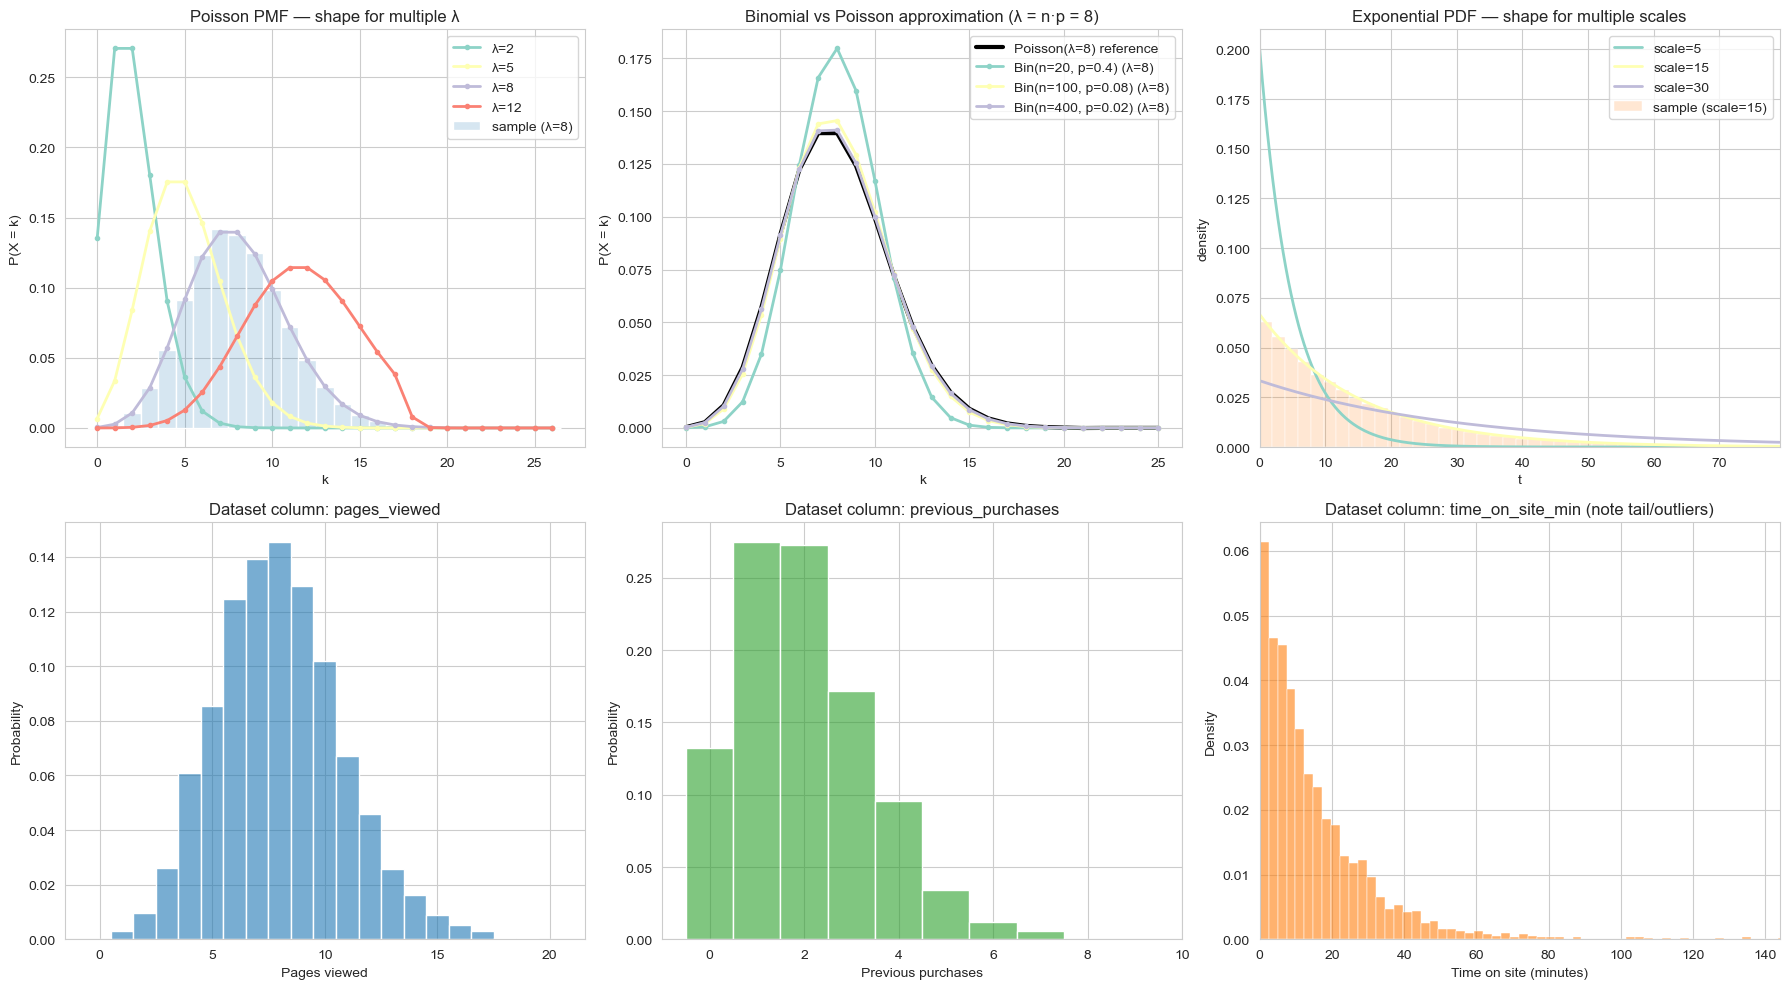

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# --- Parameters used in the synthetic generator ---
lam_pages = 8
lam_prev = 2
scale_time = 15  # mean of exponential when using numpy's "scale"

# --- NEW: parameter grids to visualize shape changes ---
lam_pages_grid = [2, 5, 8, 12]
scale_time_grid = [5, 15, 30]  # smaller=steeper decay, larger=heavier tail

# Binomial -> Poisson approximation settings (lambda = n*p)
# Good approximation when n large, p small, with lambda moderate.
binom_setups = [
    {"n": 20,  "p": 0.4},    # lambda = 8 (not "small p": approximation is worse, intentionally illustrative)
    {"n": 100, "p": 0.08},   # lambda = 8 (better)
    {"n": 400, "p": 0.02},   # lambda = 8 (typically quite good)
]

# --- Samples (for "sample vs theory" overlay) ---
n_samp = 50_000
poisson_pages = np.random.poisson(lam_pages, n_samp)
exp_time = np.random.exponential(scale_time, n_samp)

# --- PMFs/PDFs (no SciPy needed) ---
def poisson_pmf(k, lam):
    return np.exp(-lam) * (lam ** k) / math.factorial(int(k))

def binom_pmf(k, n, p):
    # Uses math.comb (Python 3.8+) and is stable for moderate n.
    return math.comb(int(n), int(k)) * (p ** int(k)) * ((1 - p) ** (int(n) - int(k)))

def poisson_k_range(lams, tail_sigma=4, k_min=0):
    lam_max = max(lams)
    k_max = int(np.ceil(lam_max + tail_sigma * np.sqrt(lam_max)))
    return np.arange(k_min, max(k_max, 1) + 1)

# --- Pull actual dataset columns if available ---
have_df = "df_raw" in globals()
if have_df:
    pages_viewed_data = df_raw["pages_viewed"].dropna()
    prev_purchases_data = df_raw["previous_purchases"].dropna()
    time_on_site_data = df_raw["time_on_site_min"].dropna()
else:
    pages_viewed_data = prev_purchases_data = time_on_site_data = None

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# =======================
# TOP ROW (general figures)
# =======================

# (1) Poisson PMF overlay: multiple lambdas
k_pages = poisson_k_range(lam_pages_grid)
for lam in lam_pages_grid:
    pmf = np.array([poisson_pmf(k, lam) for k in k_pages])
    axes[0, 0].plot(k_pages, pmf, marker="o", linewidth=2, markersize=3, label=f"λ={lam}")

# Add one sampled histogram for the generator's chosen lambda (so it connects to the synthetic generator)
sns.histplot(
    poisson_pages, discrete=True, stat="probability",
    color="tab:blue", alpha=0.18, ax=axes[0, 0], label=f"sample (λ={lam_pages})"
)
axes[0, 0].set_title("Poisson PMF — shape for multiple λ")
axes[0, 0].set_xlabel("k")
axes[0, 0].set_ylabel("P(X = k)")
axes[0, 0].legend()

# (2) Binomial vs Poisson approximation (match mean λ = n*p)
# Use a shared k-range around lambda=8 for fair visual comparison
target_lambda = 8
k_cmp = np.arange(0, 26)

poisson_ref = np.array([poisson_pmf(k, target_lambda) for k in k_cmp])
axes[0, 1].plot(k_cmp, poisson_ref, linewidth=3, color="black", label="Poisson(λ=8) reference")

for setup in binom_setups:
    n_b, p_b = setup["n"], setup["p"]
    lam = n_b * p_b
    pmf_b = np.array([binom_pmf(k, n_b, p_b) if k <= n_b else 0.0 for k in k_cmp])
    axes[0, 1].plot(k_cmp, pmf_b, marker="o", linewidth=2, markersize=3,
                    label=f"Bin(n={n_b}, p={p_b:.3g}) (λ={lam:g})")

axes[0, 1].set_title("Binomial vs Poisson approximation (λ = n·p = 8)")
axes[0, 1].set_xlabel("k")
axes[0, 1].set_ylabel("P(X = k)")
axes[0, 1].legend()

# (3) Exponential PDF overlay: multiple scales + one sampled histogram
x_max = np.percentile(exp_time, 99.5)
x = np.linspace(0, x_max, 400)

for sc in scale_time_grid:
    beta = 1.0 / sc
    pdf = beta * np.exp(-beta * x)
    axes[0, 2].plot(x, pdf, linewidth=2, label=f"scale={sc}")

sns.histplot(exp_time, bins=80, stat="density", color="tab:orange", alpha=0.18, ax=axes[0, 2],
             label=f"sample (scale={scale_time})")
axes[0, 2].set_title("Exponential PDF — shape for multiple scales")
axes[0, 2].set_xlabel("t")
axes[0, 2].set_ylabel("density")
axes[0, 2].set_xlim(0, x_max)
axes[0, 2].legend()

# =======================
# BOTTOM ROW (your dataset columns)
# =======================

# pages_viewed
if have_df:
    sns.histplot(pages_viewed_data, bins=21, discrete=True, stat="probability",
                 color="tab:blue", alpha=0.6, ax=axes[1, 0])
    axes[1, 0].set_title("Dataset column: pages_viewed")
    axes[1, 0].set_xlabel("Pages viewed")
    axes[1, 0].set_ylabel("Probability")
else:
    axes[1, 0].text(0.5, 0.5, "df_raw not found in memory", ha="center", va="center")
    axes[1, 0].set_axis_off()

# previous_purchases
if have_df:
    sns.histplot(prev_purchases_data, bins=15, discrete=True, stat="probability",
                 color="tab:green", alpha=0.6, ax=axes[1, 1])
    axes[1, 1].set_title("Dataset column: previous_purchases")
    axes[1, 1].set_xlabel("Previous purchases")
    axes[1, 1].set_ylabel("Probability")
else:
    axes[1, 1].text(0.5, 0.5, "df_raw not found in memory", ha="center", va="center")
    axes[1, 1].set_axis_off()

# time_on_site_min
if have_df:
    sns.histplot(time_on_site_data, bins=80, stat="density",
                 color="tab:orange", alpha=0.6, ax=axes[1, 2])
    axes[1, 2].set_title("Dataset column: time_on_site_min (note tail/outliers)")
    axes[1, 2].set_xlabel("Time on site (minutes)")
    axes[1, 2].set_ylabel("Density")
    axes[1, 2].set_xlim(0, np.percentile(time_on_site_data, 99.5))
else:
    axes[1, 2].text(0.5, 0.5, "df_raw not found in memory", ha="center", va="center")
    axes[1, 2].set_axis_off()

plt.tight_layout()
plt.show()



### What students should notice (quick guide)
- **Poisson(λ)**: increasing λ shifts the mass right and spreads it out (variance = λ).
- **Exponential(scale)**: larger scale → heavier tail (slower decay).
- **Binomial(n, p) → Poisson(λ=np)**: the approximation gets better as **n increases** and **p decreases**, keeping λ fixed.

If you want, I can tweak the Binomial setups to match *your* notebook story better (e.g., set \( \lambda=2 \) to mirror `previous_purchases`).

In [5]:
print("="*70)
print("STATISTICAL SUMMARY")
print("="*70)
display(df_raw.describe())

print("\n" + "="*70)
print("MISSING VALUES ANALYSIS")
print("="*70)
missing_data = pd.DataFrame({
    'Column': df_raw.columns,
    'Missing_Count': df_raw.isnull().sum(),
    'Missing_Percentage': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
display(missing_data)

purchase_rate = df_raw['purchased'].mean()
print(f"\n{'='*70}")
print(f"Overall Purchase Rate: {purchase_rate:.2%}")
print(f"{'='*70}")

STATISTICAL SUMMARY


,customer_id,age,pages_viewed,time_on_site_min,previous_purchases,email_opened,discount_pct,purchased,purchase_amount
count,5000.000000,4750.000000,5000.000000,4850.000000,4900.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,35.029895,7.989800,16.251396,2.006735,0.398000,6.320000,0.357400,127.479540
std,1443.520003,11.112186,2.799225,19.905431,1.424624,0.489534,6.305993,0.479282,182.061898
min,1.000000,18.000000,0.000000,0.011085,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1250.750000,27.000000,6.000000,4.531776,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2500.500000,35.000000,8.000000,10.741647,2.000000,0.000000,5.000000,0.000000,0.000000
75%,3750.250000,42.000000,10.000000,21.293730,3.000000,1.000000,10.000000,1.000000,300.816182
max,5000.000000,80.000000,20.000000,197.934769,9.000000,1.000000,20.000000,1.000000,792.245569



MISSING VALUES ANALYSIS


,Column,Missing_Count,Missing_Percentage
age,age,250,5.0
time_on_site_min,time_on_site_min,150,3.0
previous_purchases,previous_purchases,100,2.0



Overall Purchase Rate: 35.74%


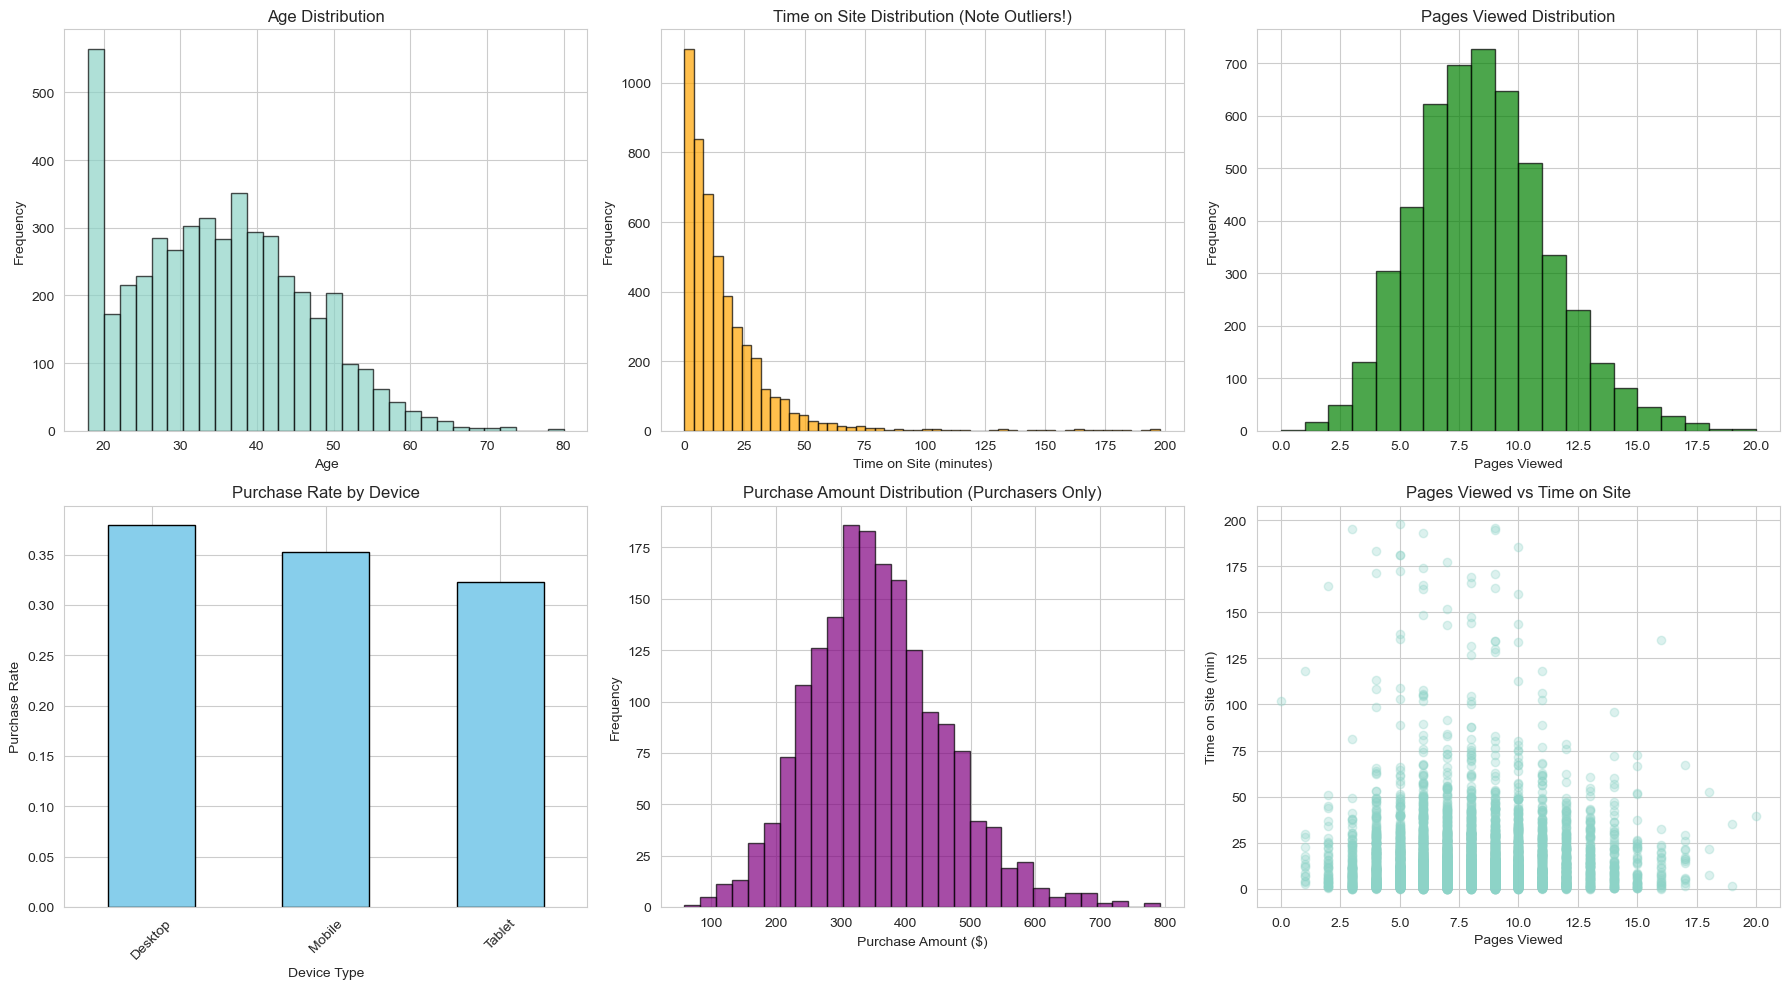

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].hist(df_raw['age'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Age Distribution')

axes[0, 1].hist(df_raw['time_on_site_min'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Time on Site (minutes)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Time on Site Distribution (Note Outliers!)')

axes[0, 2].hist(df_raw['pages_viewed'], bins=20, edgecolor='black', alpha=0.7, color='green')
axes[0, 2].set_xlabel('Pages Viewed')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Pages Viewed Distribution')

device_purchase = df_raw.groupby('device')['purchased'].mean()
device_purchase.plot(kind='bar', ax=axes[1, 0], color='skyblue', edgecolor='black')
axes[1, 0].set_xlabel('Device Type')
axes[1, 0].set_ylabel('Purchase Rate')
axes[1, 0].set_title('Purchase Rate by Device')
axes[1, 0].tick_params(axis='x', rotation=45)

purchase_amounts = df_raw[df_raw['purchased'] == 1]['purchase_amount']
axes[1, 1].hist(purchase_amounts, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_xlabel('Purchase Amount ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Purchase Amount Distribution (Purchasers Only)')

axes[1, 2].scatter(df_raw['pages_viewed'], df_raw['time_on_site_min'], alpha=0.3)
axes[1, 2].set_xlabel('Pages Viewed')
axes[1, 2].set_ylabel('Time on Site (min)')
axes[1, 2].set_title('Pages Viewed vs Time on Site')

plt.tight_layout()
plt.show()

## Part 3: Data Preprocessing with Pandas

### 3.1 Handling Missing Values

In [7]:
df = df_raw.copy()

print("="*70)
print("HANDLING MISSING VALUES")
print("="*70)

age_median = df['age'].median()
df['age'].fillna(age_median, inplace=True)
print(f"\n✓ Filled missing 'age' values with median: {age_median}")

time_mean = df['time_on_site_min'].mean()
df['time_on_site_min'].fillna(time_mean, inplace=True)
print(f"✓ Filled missing 'time_on_site_min' values with mean: {time_mean:.2f}")

df['previous_purchases'].fillna(0, inplace=True)
print(f"✓ Filled missing 'previous_purchases' values with 0")

print(f"\nMissing values after imputation: {df.isnull().sum().sum()}")
print("="*70)

HANDLING MISSING VALUES

✓ Filled missing 'age' values with median: 35.0
✓ Filled missing 'time_on_site_min' values with mean: 16.25
✓ Filled missing 'previous_purchases' values with 0

Missing values after imputation: 0


### 3.2 Handling Outliers

In [8]:
print("="*70)
print("HANDLING OUTLIERS (IQR METHOD)")
print("="*70)

Q1 = df['time_on_site_min'].quantile(0.25)
Q3 = df['time_on_site_min'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nQ1 (25th percentile): {Q1:.2f}")
print(f"Q3 (75th percentile): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

outliers = df[(df['time_on_site_min'] < lower_bound) | (df['time_on_site_min'] > upper_bound)]
print(f"\nNumber of outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

df['time_on_site_min'] = df['time_on_site_min'].clip(lower=lower_bound, upper=upper_bound)
print(f"✓ Outliers capped to [{lower_bound:.2f}, {upper_bound:.2f}]")
print("="*70)

HANDLING OUTLIERS (IQR METHOD)

Q1 (25th percentile): 4.74
Q3 (75th percentile): 20.88
IQR: 16.14
Lower bound: -19.46
Upper bound: 45.08

Number of outliers detected: 264 (5.28%)
✓ Outliers capped to [-19.46, 45.08]


### 3.3 Feature Engineering and Aggregation

In [9]:
print("="*70)
print("FEATURE ENGINEERING & AGGREGATION")
print("="*70)

df['engagement_score'] = (
    0.3 * df['pages_viewed'] / df['pages_viewed'].max() +
    0.3 * df['time_on_site_min'] / df['time_on_site_min'].max() +
    0.2 * df['email_opened'] +
    0.2 * (df['previous_purchases'] > 0).astype(int)
)
print("\n✓ Created 'engagement_score' (composite feature)")

df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 100], 
                         labels=['18-25', '26-35', '36-50', '50+'])
print("✓ Created 'age_group' (binned feature)")

print("\n" + "-"*70)
print("AGGREGATION EXAMPLE 1: Purchase Rate by Device and Country")
print("-"*70)
agg_device_country = df.groupby(['device', 'country']).agg({
    'purchased': ['count', 'sum', 'mean'],
    'purchase_amount': ['mean', 'sum']
}).round(2)
agg_device_country.columns = ['_'.join(col) for col in agg_device_country.columns]
display(agg_device_country.head(10))

print("\n" + "-"*70)
print("AGGREGATION EXAMPLE 2: Pivot Table - Avg Purchase by Device & Age Group")
print("-"*70)
pivot = pd.pivot_table(df[df['purchased'] == 1], 
                       values='purchase_amount',
                       index='device',
                       columns='age_group',
                       aggfunc='mean').round(2)
display(pivot)

df['country_avg_purchase_rate'] = df.groupby('country')['purchased'].transform('mean')
print("\n✓ Created 'country_avg_purchase_rate' (group-based feature)")

print("\n" + "="*70)
print(f"Total features after engineering: {df.shape[1]}")
print("="*70)

FEATURE ENGINEERING & AGGREGATION

✓ Created 'engagement_score' (composite feature)
✓ Created 'age_group' (binned feature)

----------------------------------------------------------------------
AGGREGATION EXAMPLE 1: Purchase Rate by Device and Country
----------------------------------------------------------------------


purchased_count  purchased_sum  purchased_mean  \
device  country                                                   
Desktop Canada               143             59            0.41   
        France               225             81            0.36   
        Germany              249             90            0.36   
        Other                162             54            0.33   
        UK                   298            125            0.42   
        USA                  396            150            0.38   
Mobile  Canada               294             97            0.33   
        France               488            167            0.34   
        Germany              457            165            0.36   
        Other                307             92            0.30   

                 purchase_amount_mean  purchase_amount_sum  
device  country                                             
Desktop Canada                 145.88             20861.27  
        France                 125.43             28221.49  
        Germany                133.24             33176.81  
        Other                  112.25             18184.30  
        UK                     151.65             45193.04  
        USA                    134.91             53423.42  
Mobile  Canada                 114.76             33739.18  
        France                 118.59             57873.55  
        Germany                136.90             62565.10  
        Other                  101.46             31147.32


----------------------------------------------------------------------
AGGREGATION EXAMPLE 2: Pivot Table - Avg Purchase by Device & Age Group
----------------------------------------------------------------------


age_group,18-25,26-35,36-50,50+
device,,,,
Desktop,343.12,359.58,363.40,348.73
Mobile,360.57,359.91,357.70,345.94
Tablet,356.17,354.82,344.62,350.66



✓ Created 'country_avg_purchase_rate' (group-based feature)

Total features after engineering: 15


### 3.4 Encoding Categorical Variables

In [10]:
print("="*70)
print("ENCODING CATEGORICAL VARIABLES")
print("="*70)

df_encoded = pd.get_dummies(df, columns=['gender', 'device', 'country'], 
                            prefix=['gender', 'device', 'country'],
                            drop_first=True)

age_group_mapping = {'18-25': 0, '26-35': 1, '36-50': 2, '50+': 3}
df_encoded['age_group_encoded'] = df_encoded['age_group'].map(age_group_mapping)
df_encoded.drop('age_group', axis=1, inplace=True)

print(f"\n✓ One-hot encoded: gender, device, country")
print(f"✓ Label encoded: age_group")
print(f"\nFinal dataset shape: {df_encoded.shape}")
print("="*70)

ENCODING CATEGORICAL VARIABLES

✓ One-hot encoded: gender, device, country
✓ Label encoded: age_group

Final dataset shape: (5000, 21)


## Part 4: Train/Validation/Test Split

### Why Three Sets?

| Dataset | Purpose | When Used | Can Be Modified? |
|---------|---------|-----------|------------------|
| **Training** | Learn model parameters | During training | Yes |
| **Validation** | Tune hyperparameters | During development | Indirectly |
| **Test** | Final evaluation | Only once at end | **NO - never** |

In [11]:
feature_cols = [col for col in df_encoded.columns 
                if col not in ['customer_id', 'purchased', 'purchase_amount']]

X = df_encoded[feature_cols]
y_classification = df_encoded['purchased']
y_regression = df_encoded['purchase_amount']

X_temp, X_test, y_cls_temp, y_cls_test, y_reg_temp, y_reg_test = train_test_split(
    X, y_classification, y_regression, test_size=0.20, random_state=42, stratify=y_classification
)

X_train, X_val, y_cls_train, y_cls_val, y_reg_train, y_reg_val = train_test_split(
    X_temp, y_cls_temp, y_reg_temp, test_size=0.25, random_state=42, stratify=y_cls_temp
)

print("="*70)
print("DATA SPLIT SUMMARY")
print("="*70)
print(f"\nTotal samples: {len(X):,}")
print(f"\nTraining set:   {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set:       {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nNumber of features: {X_train.shape[1]}")
print("="*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features scaled using StandardScaler")

DATA SPLIT SUMMARY

Total samples: 5,000

Training set:   3,000 (60.0%)
Validation set: 1,000 (20.0%)
Test set:       1,000 (20.0%)

Number of features: 18

✓ Features scaled using StandardScaler


## Part 5: Classification Task - Multiple Evaluation Metrics

### Classification Metrics Explained

| Metric | Formula | When to Use |
|--------|---------|-------------|
| **Accuracy** | (TP+TN)/(Total) | Balanced classes |
| **Precision** | TP/(TP+FP) | Cost of false positives high |
| **Recall** | TP/(TP+FN) | Cost of false negatives high |
| **F1-Score** | 2×P×R/(P+R) | Balance precision & recall |
| **ROC-AUC** | Area under ROC | Overall discrimination |

In [12]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
}

results_classification = []

for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_cls_train)
    
    y_train_pred = clf.predict(X_train_scaled)
    y_val_pred = clf.predict(X_val_scaled)
    y_test_pred = clf.predict(X_test_scaled)
    
    y_train_proba = clf.predict_proba(X_train_scaled)[:, 1]
    y_val_proba = clf.predict_proba(X_val_scaled)[:, 1]
    y_test_proba = clf.predict_proba(X_test_scaled)[:, 1]
    
    for dataset_name, y_true, y_pred, y_proba in [
        ('Train', y_cls_train, y_train_pred, y_train_proba),
        ('Validation', y_cls_val, y_val_pred, y_val_proba),
        ('Test', y_cls_test, y_test_pred, y_test_proba)
    ]:
        results_classification.append({
            'Model': name,
            'Dataset': dataset_name,
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1-Score': f1_score(y_true, y_pred),
            'ROC-AUC': roc_auc_score(y_true, y_proba)
        })

df_results_cls = pd.DataFrame(results_classification)

print("="*70)
print("CLASSIFICATION RESULTS - ALL METRICS")
print("="*70)
display(df_results_cls.round(4))

CLASSIFICATION RESULTS - ALL METRICS


,Model,Dataset,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,Train,0.6517,0.5398,0.1771,0.2667,0.6379
1,Logistic Regression,Validation,0.6370,0.4737,0.1513,0.2293,0.6092
2,Logistic Regression,Test,0.6650,0.6038,0.1793,0.2765,0.6180
3,Decision Tree,Train,0.6790,0.5833,0.3588,0.4443,0.6627
4,Decision Tree,Validation,0.6380,0.4880,0.2857,0.3604,0.6161
5,Decision Tree,Test,0.6380,0.4879,0.2829,0.3582,0.5877
6,Random Forest,Train,0.8333,0.9983,0.5349,0.6966,0.9482
7,Random Forest,Validation,0.6390,0.4836,0.1653,0.2463,0.6299
8,Random Forest,Test,0.6430,0.5000,0.1625,0.2452,0.6124


### Visualize Classification Performance

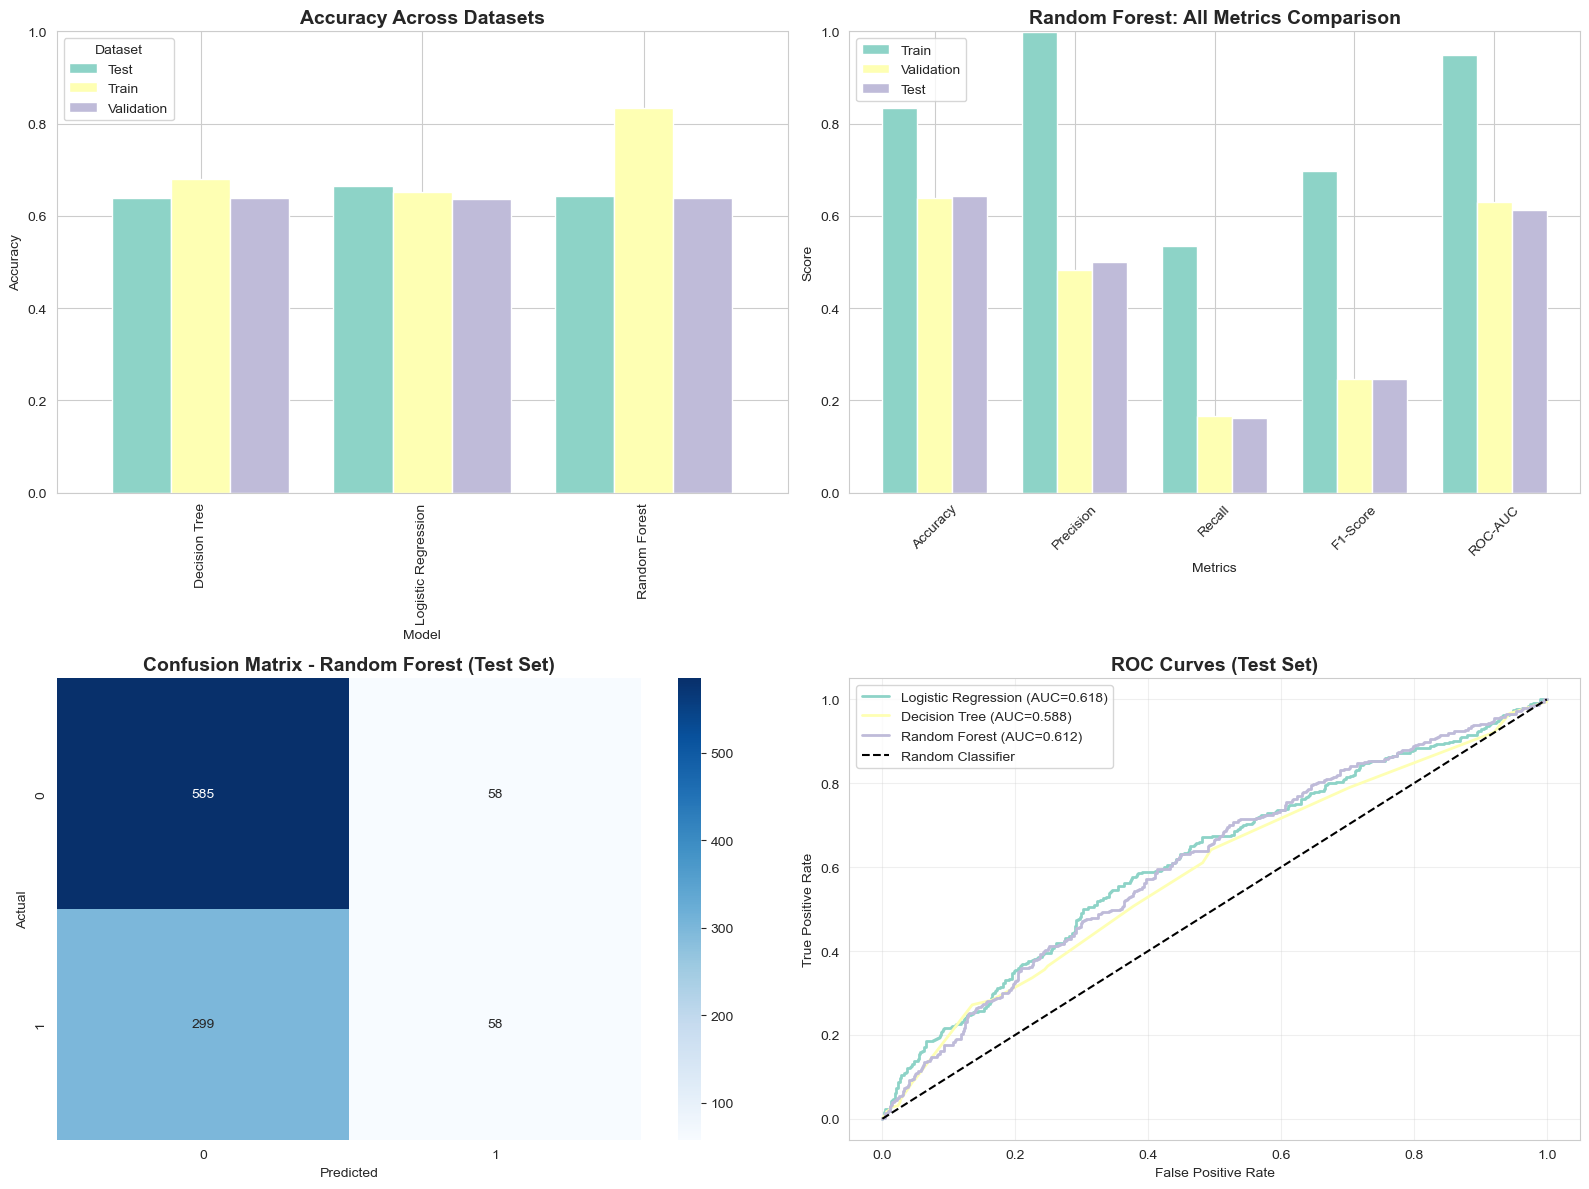

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for metric in metrics_to_plot:
    pivot_data = df_results_cls.pivot(index='Model', columns='Dataset', values=metric)
    if metric == 'Accuracy':
        pivot_data.plot(kind='bar', ax=axes[0, 0], width=0.8)
        axes[0, 0].set_title('Accuracy Across Datasets', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend(title='Dataset')
        axes[0, 0].set_ylim([0, 1])

# Plot 2: All metrics for Random Forest
rf_results = df_results_cls[df_results_cls['Model'] == 'Random Forest']
rf_results_melted = rf_results.melt(id_vars=['Model', 'Dataset'], 
                                     value_vars=metrics_to_plot,
                                     var_name='Metric', value_name='Score')
datasets = ['Train', 'Validation', 'Test']
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, dataset in enumerate(datasets):
    data = rf_results_melted[rf_results_melted['Dataset'] == dataset]
    axes[0, 1].bar(x + i*width, data['Score'], width, label=dataset)

axes[0, 1].set_xlabel('Metrics')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Random Forest: All Metrics Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x + width)
axes[0, 1].set_xticklabels(metrics_to_plot, rotation=45)
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1])

# Plot 3: Confusion Matrix for Random Forest (Test set)
rf_model = classifiers['Random Forest']
y_test_pred_rf = rf_model.predict(X_test_scaled)
cm = confusion_matrix(y_cls_test, y_test_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix - Random Forest (Test Set)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_xlabel('Predicted')

# Plot 4: ROC Curves
for name, clf in classifiers.items():
    y_test_proba = clf.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_cls_test, y_test_proba)
    auc_score = roc_auc_score(y_cls_test, y_test_proba)
    axes[1, 1].plot(fpr, tpr, label=f'{name} (AUC={auc_score:.3f})', linewidth=2)

axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curves (Test Set)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Classification Report

In [14]:
print("="*70)
print("DETAILED CLASSIFICATION REPORT - RANDOM FOREST (TEST SET)")
print("="*70)
print(classification_report(y_cls_test, y_test_pred_rf, 
                           target_names=['No Purchase', 'Purchase']))

DETAILED CLASSIFICATION REPORT - RANDOM FOREST (TEST SET)
              precision    recall  f1-score   support

 No Purchase       0.66      0.91      0.77       643
    Purchase       0.50      0.16      0.25       357

    accuracy                           0.64      1000
   macro avg       0.58      0.54      0.51      1000
weighted avg       0.60      0.64      0.58      1000



## Part 6: Regression Task - Multiple Evaluation Metrics

### Regression Metrics Explained

| Metric | Formula | Interpretation | Best Value |
|--------|---------|----------------|------------|
| **MSE** | $\frac{1}{n}\sum(y_i - \hat{y}_i)^2$ | Average squared error | 0 |
| **RMSE** | $\sqrt{MSE}$ | Error in original units | 0 |
| **MAE** | $\frac{1}{n}\sum|y_i - \hat{y}_i|$ | Average absolute error | 0 |
| **R²** | $1 - \frac{SS_{res}}{SS_{tot}}$ | Variance explained | 1 |
| **MAPE** | $\frac{100}{n}\sum\frac{|y_i - \hat{y}_i|}{y_i}$ | % error | 0 |

In [15]:
# Filter to only purchasers for regression
purchaser_idx_train = y_reg_train > 0
purchaser_idx_val = y_reg_val > 0
purchaser_idx_test = y_reg_test > 0

X_train_reg = X_train_scaled[purchaser_idx_train]
y_train_reg = y_reg_train[purchaser_idx_train]

X_val_reg = X_val_scaled[purchaser_idx_val]
y_val_reg = y_reg_val[purchaser_idx_val]

X_test_reg = X_test_scaled[purchaser_idx_test]
y_test_reg = y_reg_test[purchaser_idx_test]

print(f"Regression dataset sizes:")
print(f"  Train: {len(y_train_reg)}")
print(f"  Val:   {len(y_val_reg)}")
print(f"  Test:  {len(y_test_reg)}")

Regression dataset sizes:
  Train: 1073
  Val:   357
  Test:  357


In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

regressors = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=8, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
}

results_regression = []

for name, reg in regressors.items():
    reg.fit(X_train_reg, y_train_reg)
    
    y_train_pred = reg.predict(X_train_reg)
    y_val_pred = reg.predict(X_val_reg)
    y_test_pred = reg.predict(X_test_reg)
    
    for dataset_name, y_true, y_pred in [
        ('Train', y_train_reg, y_train_pred),
        ('Validation', y_val_reg, y_val_pred),
        ('Test', y_test_reg, y_test_pred)
    ]:
        mse = mean_squared_error(y_true, y_pred)
        results_regression.append({
            'Model': name,
            'Dataset': dataset_name,
            'MSE': mse,
            'RMSE': np.sqrt(mse),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred)
        })

df_results_reg = pd.DataFrame(results_regression)

print("="*70)
print("REGRESSION RESULTS - ALL METRICS")
print("="*70)
display(df_results_reg.round(4))

REGRESSION RESULTS - ALL METRICS


,Model,Dataset,MSE,RMSE,MAE,R²,MAPE
0,Linear Regression,Train,1220.3461,34.9335,22.1032,0.8865,6.4196
1,Linear Regression,Validation,1626.2945,40.3273,24.7882,0.8612,6.9975
2,Linear Regression,Test,1423.1980,37.7253,24.0201,0.8692,6.8849
3,Ridge Regression,Train,1220.3743,34.9339,22.0946,0.8865,6.4163
4,Ridge Regression,Validation,1625.8368,40.3217,24.7762,0.8613,6.9936
5,Ridge Regression,Test,1422.6514,37.7181,24.0105,0.8693,6.8829
6,Decision Tree,Train,475.9978,21.8174,16.0523,0.9557,5.1143
7,Decision Tree,Validation,2282.7241,47.7779,32.2960,0.8052,9.4529
8,Decision Tree,Test,2583.3533,50.8267,33.8372,0.7626,10.1921
9,Random Forest,Train,212.7248,14.5851,9.7319,0.9802,2.9051


### Visualize Regression Performance

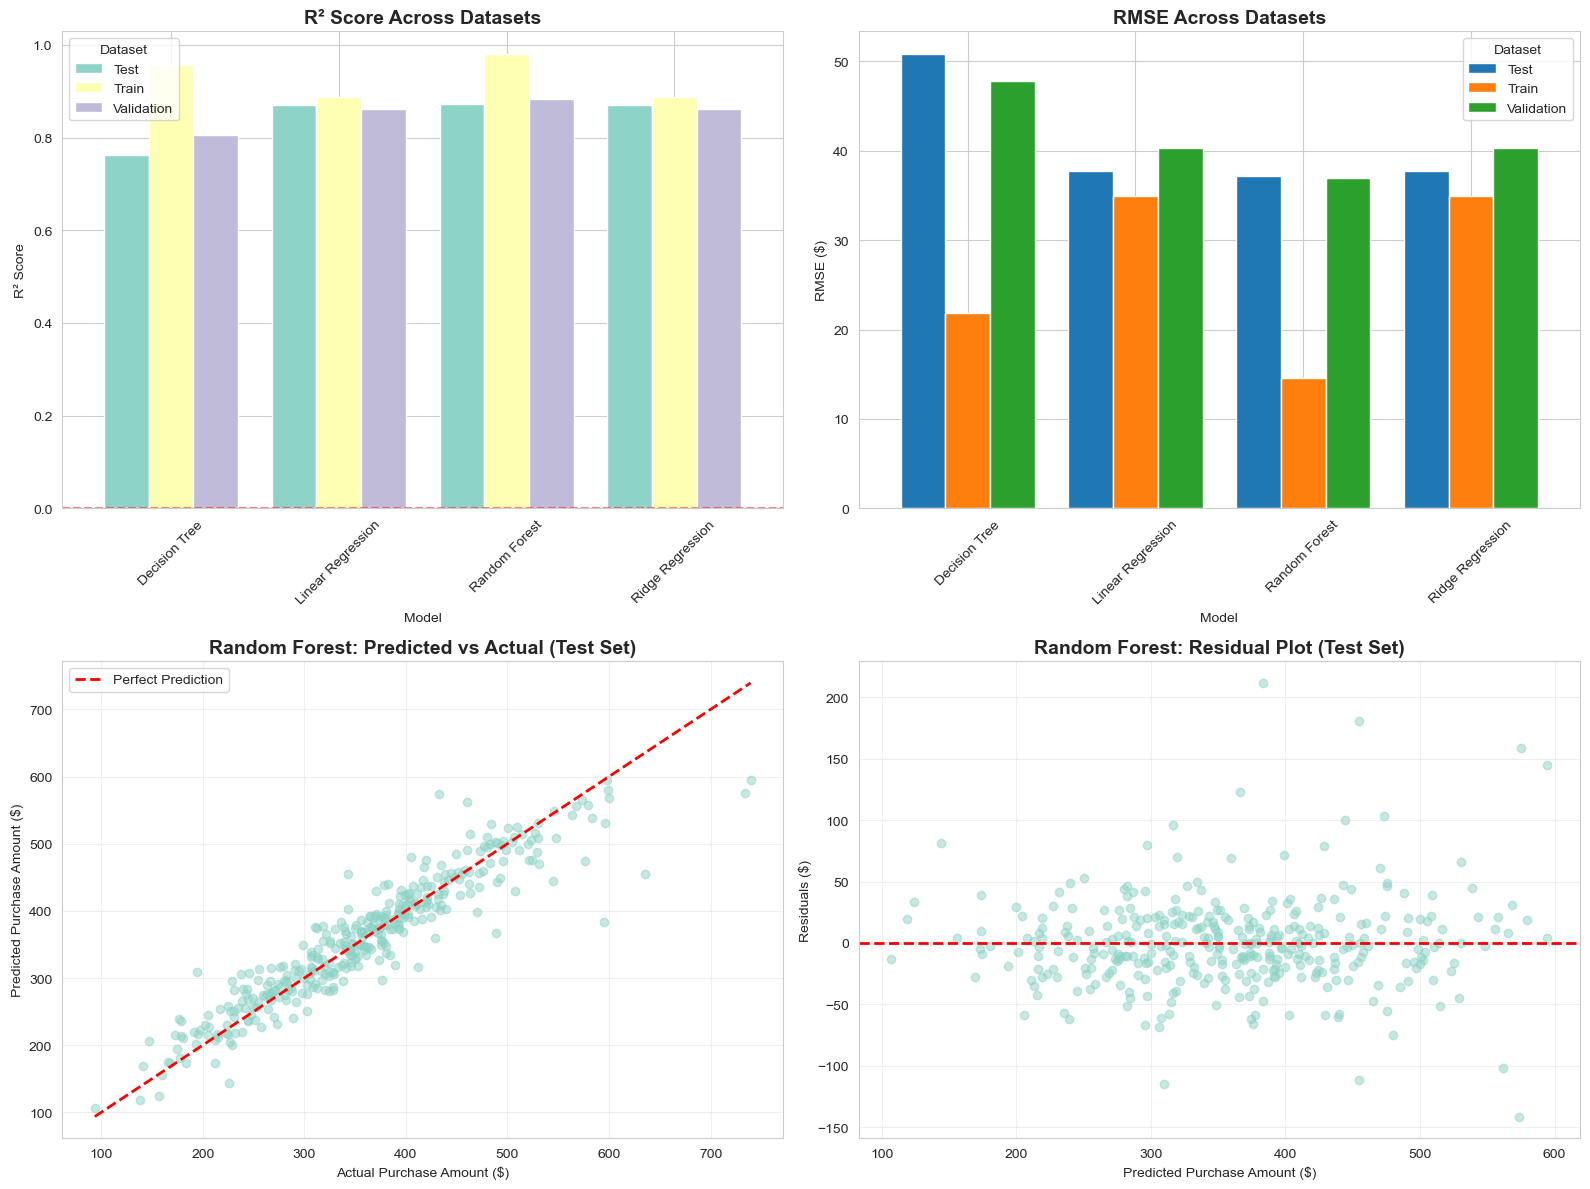

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: R² comparison
r2_pivot = df_results_reg.pivot(index='Model', columns='Dataset', values='R²')
r2_pivot.plot(kind='bar', ax=axes[0, 0], width=0.8)
axes[0, 0].set_title('R² Score Across Datasets', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].legend(title='Dataset')
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: RMSE comparison
rmse_pivot = df_results_reg.pivot(index='Model', columns='Dataset', values='RMSE')
rmse_pivot.plot(kind='bar', ax=axes[0, 1], width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 1].set_title('RMSE Across Datasets', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('RMSE ($)')
axes[0, 1].legend(title='Dataset')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Predicted vs Actual (Test set, Random Forest)
rf_reg = regressors['Random Forest']
y_test_pred_rf = rf_reg.predict(X_test_reg)

axes[1, 0].scatter(y_test_reg, y_test_pred_rf, alpha=0.5)
axes[1, 0].plot([y_test_reg.min(), y_test_reg.max()], 
                [y_test_reg.min(), y_test_reg.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Purchase Amount ($)')
axes[1, 0].set_ylabel('Predicted Purchase Amount ($)')
axes[1, 0].set_title('Random Forest: Predicted vs Actual (Test Set)', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Residuals (Test set, Random Forest)
residuals = y_test_reg - y_test_pred_rf
axes[1, 1].scatter(y_test_pred_rf, residuals, alpha=0.5)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Purchase Amount ($)')
axes[1, 1].set_ylabel('Residuals ($)')
axes[1, 1].set_title('Random Forest: Residual Plot (Test Set)', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Part 7: Understanding Overfitting and Underfitting

### Key Observations

In [18]:
print("="*70)
print("ANALYZING OVERFITTING/UNDERFITTING")
print("="*70)

for model_name in classifiers.keys():
    model_results = df_results_cls[df_results_cls['Model'] == model_name]
    
    train_acc = model_results[model_results['Dataset'] == 'Train']['Accuracy'].values[0]
    val_acc = model_results[model_results['Dataset'] == 'Validation']['Accuracy'].values[0]
    test_acc = model_results[model_results['Dataset'] == 'Test']['Accuracy'].values[0]
    
    gap_train_val = train_acc - val_acc
    gap_val_test = val_acc - test_acc
    
    print(f"\n{model_name}:")
    print(f"  Train Accuracy:      {train_acc:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Test Accuracy:       {test_acc:.4f}")
    print(f"  Train-Val Gap:       {gap_train_val:.4f}")
    print(f"  Val-Test Gap:        {gap_val_test:.4f}")
    
    if gap_train_val > 0.05:
        print(f"  ⚠️  Signs of OVERFITTING (large train-val gap)")
    elif train_acc < 0.70:
        print(f"  ⚠️  Signs of UNDERFITTING (low train accuracy)")
    else:
        print(f"  ✓ Good generalization")

print("\n" + "="*70)

ANALYZING OVERFITTING/UNDERFITTING

Logistic Regression:
  Train Accuracy:      0.6517
  Validation Accuracy: 0.6370
  Test Accuracy:       0.6650
  Train-Val Gap:       0.0147
  Val-Test Gap:        -0.0280
  ⚠️  Signs of UNDERFITTING (low train accuracy)

Decision Tree:
  Train Accuracy:      0.6790
  Validation Accuracy: 0.6380
  Test Accuracy:       0.6380
  Train-Val Gap:       0.0410
  Val-Test Gap:        0.0000
  ⚠️  Signs of UNDERFITTING (low train accuracy)

Random Forest:
  Train Accuracy:      0.8333
  Validation Accuracy: 0.6390
  Test Accuracy:       0.6430
  Train-Val Gap:       0.1943
  Val-Test Gap:        -0.0040
  ⚠️  Signs of OVERFITTING (large train-val gap)



## Part 8: Summary and Best Practices

### Data Preprocessing Checklist

✅ **Handle missing values** appropriately (median/mean/mode)
✅ **Detect and handle outliers** (IQR, Z-score, capping)
✅ **Feature engineering** (create meaningful features)
✅ **Encode categorical variables** (one-hot or label encoding)
✅ **Scale features** (StandardScaler, MinMaxScaler)

### Train/Val/Test Split Best Practices

✅ **Always use three sets** when tuning hyperparameters
✅ **Fit preprocessing only on training data**
✅ **Never touch test set** until final evaluation
✅ **Use stratification** for imbalanced classification
✅ **Set random_state** for reproducibility

### Metric Selection Guide

**Classification:**
- Balanced classes → Accuracy
- Imbalanced classes → F1-Score, ROC-AUC
- False positives costly → Precision
- False negatives costly → Recall

**Regression:**
- General purpose → RMSE, R²
- Robust to outliers → MAE
- Percentage error → MAPE

### Recognizing Problems

| Symptom | Diagnosis | Solution |
|---------|-----------|----------|
| Train >> Val/Test | Overfitting | Regularization, simpler model, more data |
| Train ≈ Val ≈ Test (all low) | Underfitting | More complex model, more features |
| Val >> Test | Lucky split | Use cross-validation |
| Val << Test | Data leakage | Check preprocessing pipeline |

## Exercises

### Exercise 1: Feature Importance
Extract and visualize feature importances from the Random Forest classifier. Which features are most predictive?

### Exercise 2: Threshold Tuning
The default classification threshold is 0.5. Try different thresholds and observe how precision/recall trade off.

### Exercise 3: Cross-Validation
Implement k-fold cross-validation and compare results with the single train/val/test split.

### Exercise 4: Handle Imbalance
The purchase rate is around 40%. Try techniques like SMOTE or class weighting to handle the imbalance.

### Exercise 5: Hyperparameter Tuning
Use the validation set to tune hyperparameters (e.g., max_depth for Decision Tree) and evaluate on test set.

## Further Reading

- **Pandas Documentation**: https://pandas.pydata.org/docs/
- **Scikit-learn Metrics**: https://scikit-learn.org/stable/modules/model_evaluation.html
- **Hands-On Machine Learning** by Aurélien Géron
- **Python Data Science Handbook** by Jake VanderPlas

---

**🎓 Congratulations! You now understand:**
- Data preprocessing with pandas
- Proper train/validation/test splits
- Multiple evaluation metrics for classification and regression
- How to detect and diagnose overfitting/underfitting